In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train=pd.read_csv('input/train_older.csv')
test=pd.read_csv('input/test_older.csv')
sample=pd.read_csv('input/sample_submission.csv')

### variable independence and EDA

In [9]:
from scipy.stats import pearsonr

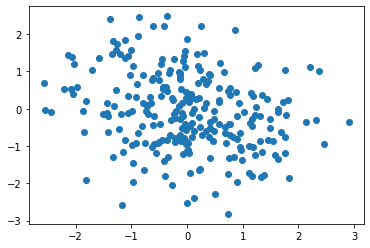

In [66]:
x=train.iloc[:,6]
y=train.iloc[:,172]
plt.scatter(x,y)

In [12]:
train.iloc[:,[2,3]].corr()

,0,1
0,1.000000,-0.003871
1,-0.003871,1.000000


In [49]:
n=train.shape[1]
p_significant=[]
for i in range(2,n-1):
    for j in range(i+1,n):
        _,p=pearsonr(train.iloc[:,i],train.iloc[:,j])
        if p<0.001:
            p_significant.append((i,j,p))

In [87]:
a=train.iloc[:,6]
b=train.iloc[:,[172]]
lr=LinearRegression()
lr.fit(b,a)
c=a-lr.predict(b)
pearsonr(c,a)

(0.9700350662130535, 2.148833013803579e-154)

In [69]:
lr.coef_

array([-0.24100349])

In [50]:
cols_to_drop= list(set([b for _,b,_ in p_significant]))

In [52]:
df= train.drop(train.columns[cols_to_drop],axis=1)

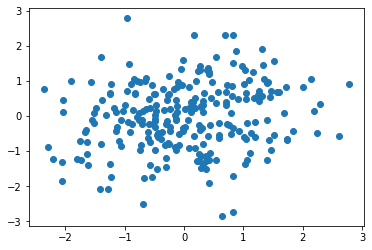

In [53]:
x=train.iloc[:,5]
y=train.iloc[:,7]
plt.scatter(x,y)

### Modeling

In [67]:
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, train_test_split, GridSearchCV
from sklearn.feature_selection import RFECV,RFE
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.metrics import roc_auc_score

In [54]:
X=df.iloc[:,2:]
y=df.iloc[:,1]
Xtest=test.iloc[:,1:]

In [55]:
lg=LogisticRegression(solver='liblinear', penalty='l1',C=0.1,class_weight='balanced')
param_grid={'C':[0.001,0.01,0.1,1,10,100,1000], 'class_weight':['balanced',None], 'penalty':['l1','l2']}
gcv=GridSearchCV(lg,param_grid,cv=5,scoring='roc_auc',n_jobs=-1)
gcv.fit(X,y)

GridSearchCV(cv=5,
             estimator=LogisticRegression(C=0.1, class_weight='balanced',
                                          penalty='l1', solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'class_weight': ['balanced', None],
                         'penalty': ['l1', 'l2']},
             scoring='roc_auc')

In [56]:
gcv.best_params_

{'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1'}

In [57]:
gcv.best_score_

0.8319444444444445

In [58]:
lg=LogisticRegression(solver='liblinear', penalty='l1',C=0.1,class_weight='balanced')
rfe=RFECV(lg,cv=5,scoring='roc_auc',n_jobs=-1)
rfe.fit(X,y)

RFECV(cv=5,
      estimator=LogisticRegression(C=0.1, class_weight='balanced', penalty='l1',
                                   solver='liblinear'),
      n_jobs=-1, scoring='roc_auc')

In [60]:
X.iloc[:,rfe.support_].shape

(250, 29)

In [62]:
#features = [ '16', '33', '43', '45', '52', '63', '65', '73', '90', '91', '117', '133', '134', '149', '189', '199', '217', '237', '258', '295']
features=X.iloc[:, rfe.support_].columns

folds=RepeatedStratifiedKFold(n_splits = 5, n_repeats = 50, random_state = 42)
preds=[]
params = {'random_state':300, 'C':0.1, 'penalty':'l1', 'solver':'liblinear','verbose':0, 'class_weight':'balanced'}	
for train_id, val_id in folds.split(X,y):
    train_x, train_y = X[features].iloc[train_id], y.iloc[train_id]
    val_x, val_y = X[features].iloc[val_id], y.iloc[val_id]
    clf = LogisticRegression(**params)
    clf.fit(train_x, train_y)
    predict=clf.predict_proba(Xtest[features])[:,1:]
    preds.append(predict)
preds=np.concatenate(preds,axis=1)

In [32]:
p=gcv.predict_proba(Xtest)[:,1]

In [63]:
sample['target']=preds.mean(1)
sample.to_csv('submission.csv',index=False)